# Simulations with regressions

In [319]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [760]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut

In [321]:
import sys
sys.path.append('./shapley_compute/')

## Independent features for linear regression

In [856]:
from shapley_compute.ensembled_mp import mp_shapley
from shapley_compute.minipatches import minipatch_regression_loo,minipatch_regression, get_minipatch

In [914]:
def normal_linear_model(N, M, sigma2=0.4, s=0.2):
    """
    N: number of obs
    M: number of features
    sigma2: variance 
    s: sparsity level
    """ 
    np.random.seed(123)
    X = np.random.normal(0,1, size=(N,M))
    M1=int(s*M)
    beta = np.append(np.random.normal(10, 1, M1),np.array([0]*(M-M1))) # M-M1 beta are set to 0, M1 are non zeros
    eps = np.random.normal(0, sigma2, size=N)

    y = X@beta + eps
    return y, X, beta
    


In [942]:
N = 2000
M = 20
y, X, beta = normal_linear_model(N,M)
B = 1000
x_ratio = 0.5
model = LinearRegression()

In [932]:
beta

array([11.91224988,  9.73172857,  9.22065083, 11.0975299 ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [917]:
predictions, in_mp_obs, in_mp_feature  = minipatch_regression(X, y, X, model, x_ratio, B)

### build

In [577]:
predictions.shape

(1000, 1000, 1)

In [578]:
predictions[:,:,0].shape, in_mp_obs.shape, in_mp_feature.shape

((1000, 1000), (1000, 1000), (1000, 20))

In [579]:
predictions.shape #in_mp_obs[b,:]

(1000, 1000, 1)

In [490]:
b = 1
predictions[b,in_mp_obs[b,:]].shape

(200, 1)

In [597]:
np.sum(in_mp_obs, axis=1)[:5], np.sum(in_mp_feature, axis=1)[:5]

(array([200, 200, 200, 200, 200]), array([12, 14, 11,  6,  4]))

In [629]:
np.sum(in_mp_obs, axis=1)[0]

200

In [669]:
j = 2
index_batch_withj = np.where(~in_mp_feature[:,j])[0]
len(index_batch_withj)

498

In [688]:
index_batch_withj = np.where(~in_mp_feature[:,j])[0] # indices of the batches without feature j
batch_size = np.sum(in_mp_obs, axis=1)[0] 
obs_batch = len(index_batch_withj)
pred_obs = np.where(in_mp_obs[index_batch_withj,:])[1].reshape((obs_batch,batch_size)) 
# for each of the batches without feature j, column is the batch observation index

for b in range(pred_obs.shape[0]):
    obs_idx = index_batch_withj[b]
    pred_j.append(predictions[b,pred_obs[b],0])

In [689]:
predictions[2, pred_obs[2], 0][:5]

array([ 11.57487094, -10.65717088,   0.56145803,   7.59945729,
         1.17558507])

In [690]:
pred_j = []
for b in range(pred_obs.shape[0]):
    obs_idx = index_batch_withj[b]
    pred_j.append(predictions[b,pred_obs[b],0])

In [703]:
reshaped_pred = np.array(pred_j).reshape(pred_obs.shape[0], batch_size)

In [707]:
np.mean(reshaped_pred, axis=0).shape

(200,)

In [654]:
index_obs_without_1 = in_mp_obs[~np.where(in_mp_feature[:,1])[0]]

In [648]:
np.where(in_mp_feature[:,1])[0].shape,np.where(in_mp_feature[:,5])[0].shape

((509,), (496,))

In [504]:
predictions[:, in_mp_obs[b,:]].shape

(1000, 200, 1)

In [728]:
j = 2
pred_j = np.mean(predictions[~np.where(in_mp_feature[:,j])[0],:, 0] * in_mp_obs[~np.where(in_mp_feature[:,j])[0],:], axis=0)

In [735]:
predictions[~np.where(in_mp_feature[:,j])[0],:10, 0] 


array([[ -7.92850378,  16.086718  , -14.38038654, ...,   4.13189419,
          3.6728702 ,  14.6199591 ],
       [  6.78762504,   9.37661405, -16.89238744, ...,  -0.57770012,
         -4.58784222,  10.64186144],
       [  0.29111025,  -6.01133399,  -3.19349532, ...,   5.38100185,
         -0.4791148 ,   6.04316693],
       ...,
       [  0.06027247,  11.21362566, -20.36612008, ...,   1.47058047,
          1.10923177,  20.49429538],
       [ -9.39563967,   8.4533226 ,   4.84005988, ...,   3.85302197,
          5.50535382,  -1.79640691],
       [ -8.55220449,  -1.54678541,  -6.03456898, ...,   2.65554331,
          1.20459064,   7.57333938]])

In [739]:
(predictions[~np.where(in_mp_feature[:,j])[0],:, 0] * in_mp_obs[~np.where(in_mp_feature[:,j])[0],:]).shape

(498, 1000)

<Axes: >

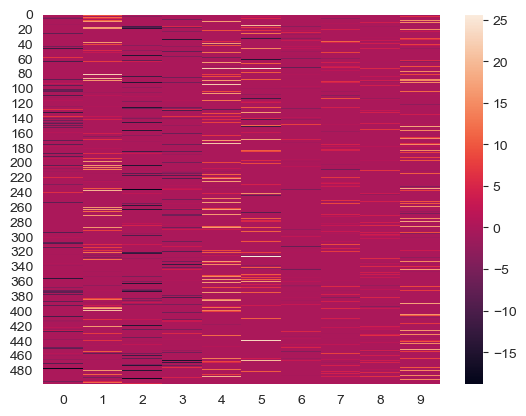

In [737]:
sns.heatmap(predictions[~np.where(in_mp_feature[:,j])[0],:10, 0] * in_mp_obs[~np.where(in_mp_feature[:,j])[0],:10])

In [724]:
pred_j2 = pred_j[np.nonzero(pred_j)]
pred_j2.shape

TypeError: tuple indices must be integers or slices, not tuple

IndexError: Inconsistent shape between the condition and the input (got (1000, 1) and (1000,))

### build MP with loo

In [761]:
X_arr = X.copy()

In [747]:
pred = np.sum(predictions[:,:, 0] * in_mp_obs, axis=0)/batch_size 
pred.shape

(1000,)

In [810]:
i = 5
j = 2
indices_without_i = np.where(~in_mp_obs[:, i])[0]
in_mp_obs_i = in_mp_obs[indices_without_i,:] # batches without observation i 
y_i = y[indices_without_i]
predictions_i = predictions[indices_without_i, :, 0]
in_mp_feature_i = in_mp_feature[indices_without_i,:]


-1475.6048996704699

In [811]:
mu_ij = np.mean(predictions_i[~np.where(in_mp_feature_i[:,j])[0],i]) # prediction without obs j with LOO i 
mu_i = np.mean(predictions_i[:,i]) # loo prediction
mu_i, mu_ij, y[i]

(5.397323578300633, 5.144132941218381, 10.44553419108121)

We can interpret our inference target $\Delta_j (X,Y )$ as the expected prediction
performance improvement if including feature $j$, given all other features, when the predictive model is trained using
minipatch ensembles on the observed training data.

In [1068]:
x_ratio = 0.2
B = 1000

In [970]:
pred.shape

(1000, 2000, 1)

In [1069]:

N = len(X)
M = len(X[0])
Delta = np.zeros((N, M))
pred, in_mp_obs, in_mp_feature = minipatch_regression(X, y, X, model, x_ratio, B)
batch_size = np.sum(in_mp_obs, axis=1)[0] 
for i in tqdm.tqdm(range(N)):
    indices_without_i = np.where(~in_mp_obs[:, i])[0] # batches without observation i
    predictions_i = pred[indices_without_i, :, 0] # predictions from batches trained without observation i on obs i (test sets of MP)
    mu_i = np.mean(predictions_i[:,i]) # average loo prediction of all 'test' out-of-batches 
    in_mp_feature_i = in_mp_feature[indices_without_i,:] # reduced feature matrix
    for j in range(M):
        # error of mu_j - error of mu
        mu_ij = np.mean(predictions_i[~np.where(in_mp_feature_i[:,j])[0],i]) # prediction without obs j with LOO i 
        err_j = np.mean(np.abs(y[i] - mu_ij)) # on minipatch without j 
        err = np.mean(np.abs(y[i] - mu_i)) # on all minipatches
    
        Delta[i,j] = err_j - err
        

100%|██████████| 2000/2000 [00:02<00:00, 871.77it/s] 


<BarContainer object of 20 artists>

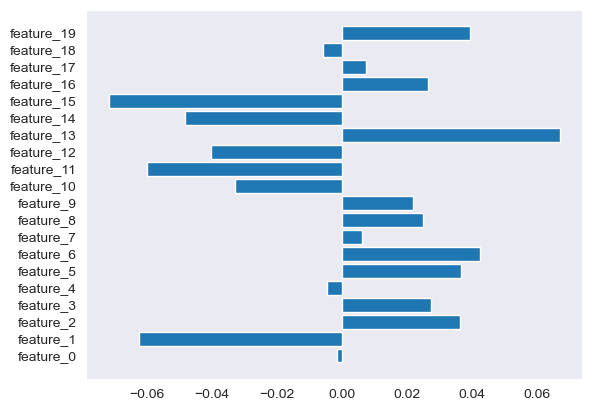

In [1070]:
plt.barh(['feature_{}'.format(i) for i in range(M)], np.mean(Delta, axis=0))

<BarContainer object of 20 artists>

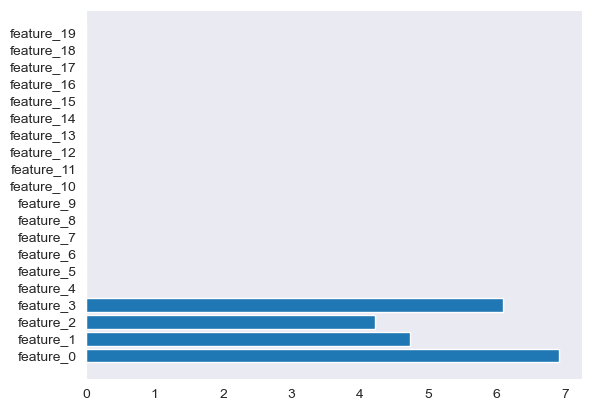

In [899]:
plt.barh(['feature_{}'.format(i) for i in range(M)], beta)

In [910]:
pd.DataFrame(Delta).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.545805,0.435550,0.302760,0.263617,-0.068396,0.212925,0.947241,-0.269070,0.029869,-0.039557,0.333867,0.532886,0.334478,0.358758,-0.043460,-0.514372,0.952287,-0.016562,0.225990,0.361863
1,-0.710175,-0.029641,-1.004102,-0.211098,-0.395058,-0.460019,-0.006602,-0.138914,-0.368355,-0.046138,0.137070,-0.362377,-0.486503,-0.024718,-0.676224,-0.337586,-0.573008,-0.302783,-0.502594,0.156749
2,0.208939,0.323616,-0.664768,0.023957,-0.510775,-0.754877,-0.325557,0.174151,-0.753182,-1.056389,-0.092926,-0.323473,-0.592620,0.025052,0.019389,-0.133686,-0.309821,-0.555755,-0.057441,-0.143163
3,0.571823,0.046756,-0.264068,0.432874,0.603070,-0.140842,-0.307854,-0.013235,0.027206,-0.020866,0.318287,0.318306,0.146726,0.418828,0.097559,0.247877,-0.397818,0.443517,0.328859,0.039972
4,-0.186086,0.859099,0.084177,0.388507,0.439249,0.577126,0.677400,0.457470,0.136530,-0.108570,0.432699,0.178855,0.205316,0.464856,1.023122,-0.644534,0.809868,0.614100,1.264764,0.409221


### Final

In [988]:
def loco_error(X, y, model, x_ratio, B):
    N = len(X)
    M = len(X[0])
    Delta = np.zeros((N, M))
    pred, in_mp_obs, in_mp_feature = minipatch_regression(X, y, X, model, x_ratio, B)
    batch_size = np.sum(in_mp_obs, axis=1)[0] 
    for i in tqdm.tqdm(range(N)):
        indices_without_i = np.where(~in_mp_obs[:, i])[0] # batches without observation i
        predictions_i = pred[indices_without_i, :, 0] # predictions from batches trained without observation i on obs i (test sets of MP)
        mu_i = np.mean(predictions_i[:,i]) # average loo prediction of all 'test' out-of-batches 
        in_mp_feature_i = in_mp_feature[indices_without_i,:] # reduced feature matrix
        for j in range(M):
            # error of mu_j - error of mu
            mu_ij = np.mean(predictions_i[~np.where(in_mp_feature_i[:,j])[0],i]) # prediction without obs j with LOO i 
            err_j = np.mean(np.abs(y[i] - mu_ij)) # on minipatch without j 
            err = np.mean(np.abs(y[i] - mu_i)) # on all minipatches
        
            Delta[i,j] = err_j - err
        
    return Delta

In [1056]:
from locomp import LOCOMPReg

<BarContainer object of 20 artists>

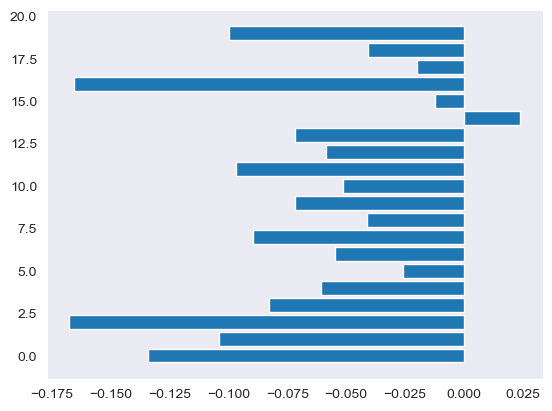

In [1064]:
plt.barh([i for i in range(M)],np.mean(Delta, axis=0))

In [1048]:
res = LOCOMPReg(X,y,x_ratio,B,model, selected_features=[],alpha=0.1,bonf=True)

In [1050]:
res['info'].groupby('j').mean().zz.head()

j
0    4.700235
1    3.739963
2    3.732653
3    4.281983
4    2.798309
Name: zz, dtype: float64

In [1051]:
res['loco_ci'][:5]

array([[0.        , 0.        , 4.42953569, 4.97093451],
       [0.        , 0.        , 3.50536001, 3.97456622],
       [0.        , 0.        , 3.48739446, 3.9779119 ],
       [0.        , 0.        , 4.0246805 , 4.53928608],
       [0.        , 0.        , 2.66257536, 2.93404229]])

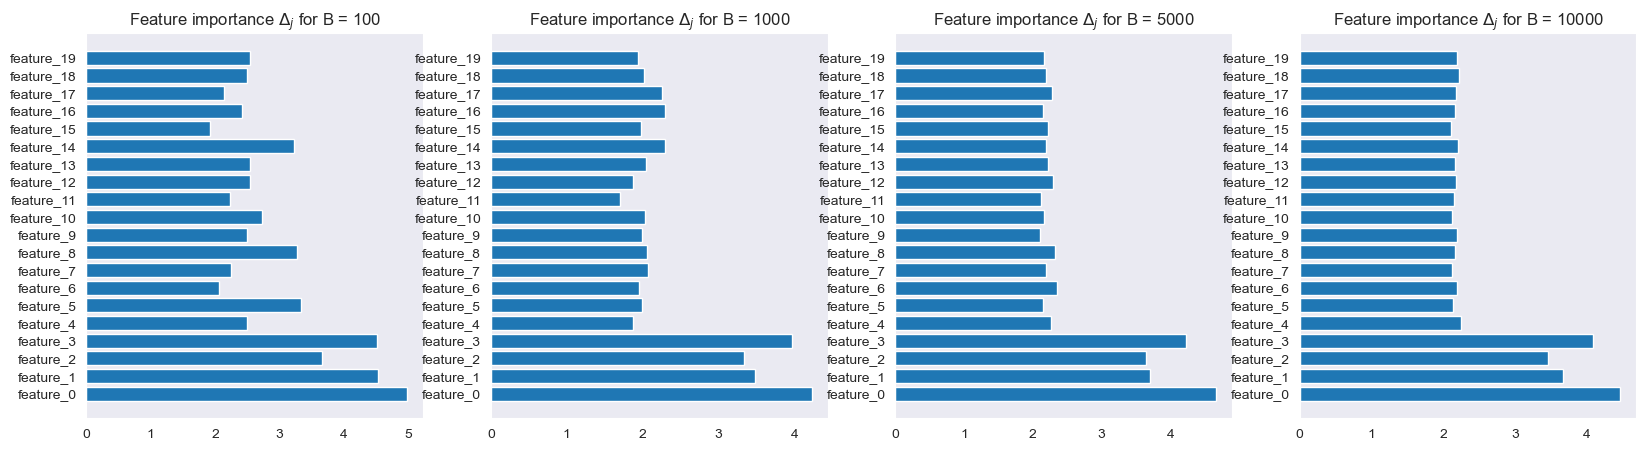

In [1055]:

list_B = [100, 1000, 5000, 10000]
fig, ax = plt.subplots(1,len(list_B), figsize=(20,5))

for b in range(len(list_B)):
    res = LOCOMPReg(X,y,x_ratio,list_B[b],model, selected_features=[],alpha=0.1,bonf=True)
    ax[b].barh(['feature_{}'.format(i) for i in range(M)], res['info'].groupby('j').mean().zz)
    ax[b].set_title('Feature importance $\Delta_j$ for B = {}'.format(list_B[b]))
plt.savefig('./figures/og_locomp_B.svg')

array([-10.35961873,  15.23703136, -12.27892675, ..., -17.96294294,
        -1.34115919,  -6.87759357])

In [400]:
len(loco_ci[0]), ress.shape,len(diff)

(4, (20000, 7), 1000)

In [418]:
loco_mp = ress[[0, 'j','zz']].groupby('j').mean()

In [408]:
len(diff)

1000

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(13,4))
ax.barh(['feature_{}'.format(i) for i in range(M)], np.mean(np.abs(shap_values_lr.values),axis=0), color='blue')
ax.barh(['feature_{}'.format(i) for i in range(M)], np.mean(np.abs(kernel_shap_values.values),axis=0), color='red', alpha=0.6)
ax.barh(['feature_{}'.format(i) for i in range(M)], np.mean(np.abs(shap_v),axis=0), color='green', alpha=0.3)
ax.legend(['exact','SHAP', 'minipatch'])

### Toy example $M = 20$

In [ ]:
# fit a linear regression and evaluate shapley mp
res = minipatch_regression_loo(X, y, model, x_ratio, B)
pred, in_mp_obs, in_mp_loo, in_mp_feature = res
X_test = X[np.unique(np.where(in_mp_loo==True)[1])]
X_train =  X[np.unique(np.where(in_mp_loo==False)[1])]
y_train =  y[np.unique(np.where(in_mp_loo==False)[1])]

shap_v = mp_shapley(X_test, res)

In [ ]:
all_features = np.unique(in_mp_feature,axis=0) # get all features sampled in MPs
print(all_features.shape[0], 2**M)

In [ ]:
plt.barh(['feature_{}'.format(i) for i in range(M)], np.mean(np.abs(shap_v),axis=0))

In [160]:
import shap
model = LinearRegression()
model.fit(X_train ,y_train)
explainer = shap.Explainer(model.predict, X_test)
## Calculates the SHAP values - It takes some time
shap_values_lr = explainer(X_test)

In [167]:
X_test.shape

(41, 20)

In [162]:
kernel_exp = shap.KernelExplainer(model.predict, X_test)
kernel_shap_values = kernel_exp(X_test)

100%|██████████| 41/41 [00:11<00:00,  3.62it/s]


In [177]:
shap_values_lr.values.shape

(41, 20)

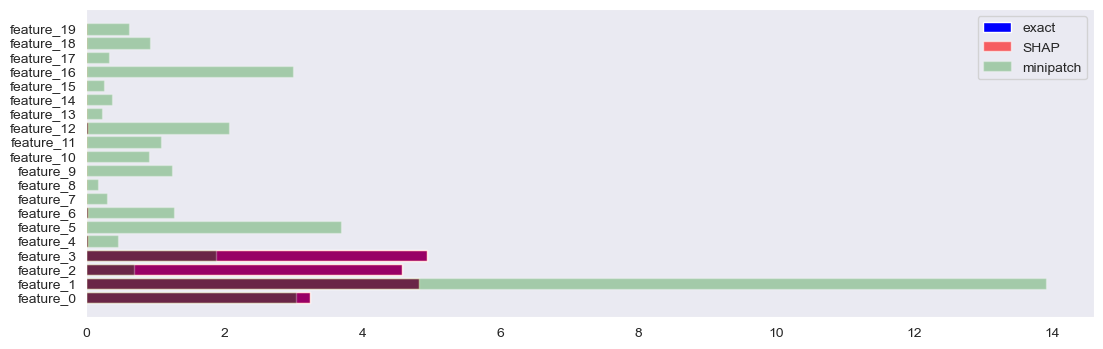

In [199]:
fig, ax = plt.subplots(1, 1, figsize=(13,4))
ax.barh(['feature_{}'.format(i) for i in range(M)], np.mean(np.abs(shap_values_lr.values),axis=0), color='blue')
ax.barh(['feature_{}'.format(i) for i in range(M)], np.mean(np.abs(kernel_shap_values.values),axis=0), color='red', alpha=0.6)
ax.barh(['feature_{}'.format(i) for i in range(M)], np.mean(np.abs(shap_v),axis=0), color='green', alpha=0.3)
ax.legend(['exact','SHAP', 'minipatch'])

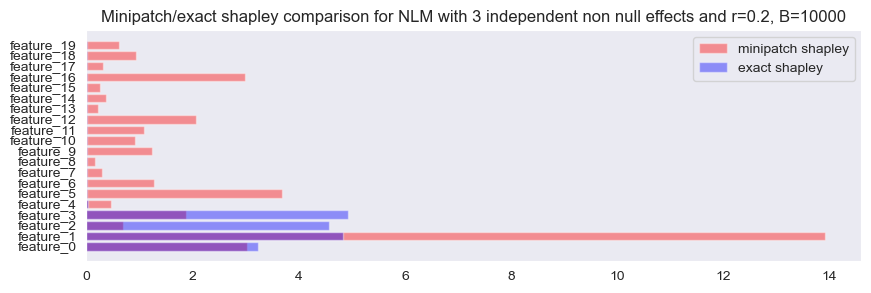

In [200]:
fig, ax = plt.subplots(figsize=(10,3))
ax.barh(['feature_{}'.format(i) for i in range(M)], np.mean(np.abs(shap_v),axis=0), alpha=0.4, color='red')
ax.barh(['feature_{}'.format(i) for i in range(M)], np.mean(np.abs(shap_values_lr.values),axis=0), alpha = 0.4, color='blue')
ax.legend(['minipatch shapley', 'exact shapley'])
ax.set_title('Minipatch/exact shapley comparison for NLM with 3 independent non null effects and r={}, B={}'.format(x_ratio, B))
plt.savefig('./figures/NLM_shap_reg_2.svg')

In [123]:
import tqdm

In [128]:
res[2].shape

(10000, 1000)

In [212]:
x_ratio = [0.03, 0.05, 0.1]
B = [5000, 10000, 20000]
shap_dict = {}
for i in tqdm.tqdm(range(len(x_ratio))):
    res = minipatch_regression_loo(X, y, model, x_ratio[i], B[i])
    X_test = X[np.unique(np.where(res[2] == True)[1]),:] 
    shap_dict[i] = mp_shapley(X_test, res)

100%|██████████| 3/3 [00:23<00:00,  7.87s/it]


In [211]:
help(mp_shapley)

Help on function mp_shapley in module shapley_compute.ensembled_mp:

mp_shapley(Xi, res)



In [214]:
X_test.shape

(75, 20)

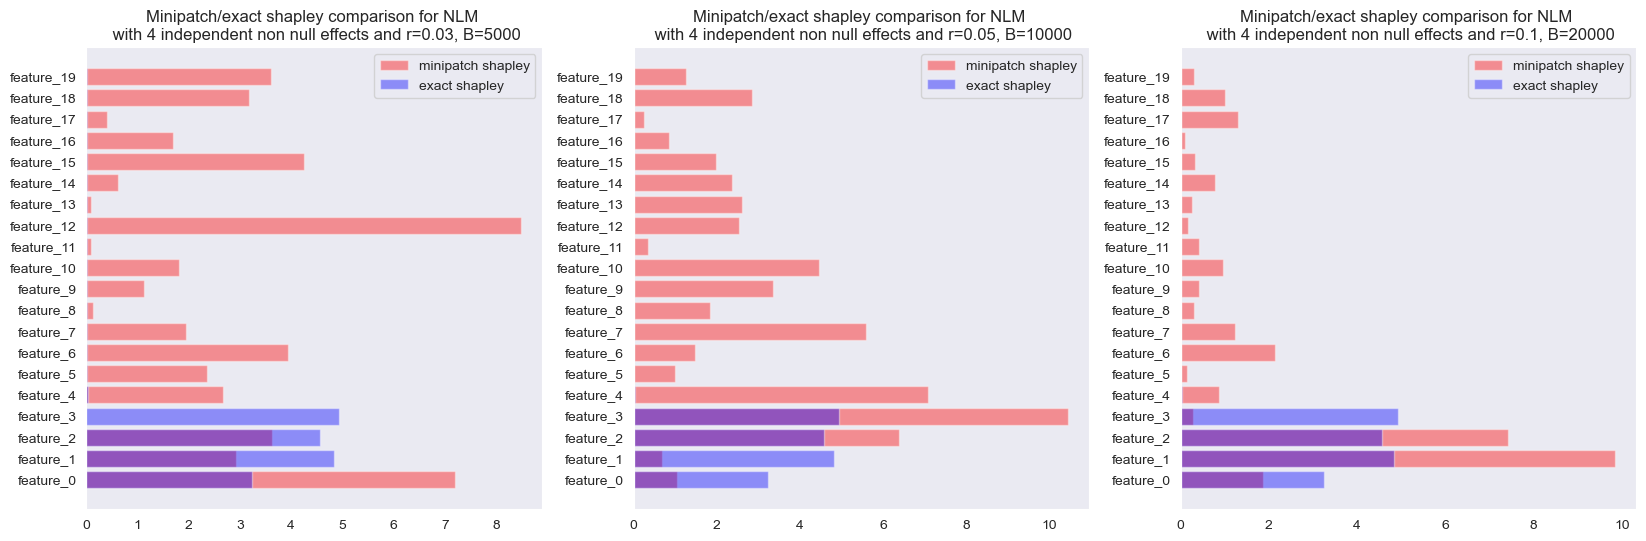

In [218]:
fig, ax = plt.subplots(1, 3, figsize=(20,6))
for i in range(len(x_ratio)):
    ax[i].barh(['feature_{}'.format(i) for i in range(M)], np.mean(np.abs(shap_dict[i]),axis=0), alpha=0.4, color='red')
    ax[i].barh(['feature_{}'.format(i) for i in range(M)], np.mean(np.abs(shap_values_lr.values), axis=0), alpha = 0.4, color='blue')
    ax[i].legend(['minipatch shapley', 'exact shapley'])
    ax[i].set_title('Minipatch/exact shapley comparison for NLM \n with {} independent non null effects and r={}, B={}'.format(len(beta[~(beta ==0)]), x_ratio[i], B[i]))
    # ax[i].yaxis.set_ticklabels([])
plt.savefig('./figures/NLM_shap_reg_2.svg')

### High dimensional example $M = 200$

In [306]:
N = 10000
M = 200
y, X, beta = normal_linear_model(N,M)
B = 100000
x_ratio = 0.05
model = LinearRegression()

In [307]:
x_ratio*N > M, x_ratio*N

(True, 500.0)

In [308]:
# fit a linear regression with minipatch and evaluate shapley mp
res = minipatch_regression_loo(X, y, model, x_ratio, B)
X_test = X[np.unique(np.where(res[2]==True)[1])]
X_train =  X[np.unique(np.where(res[2]==False)[1])]
y_train =  y[np.unique(np.where(res[2]==False)[1])]
pred, in_mp_obs, in_mp_loo, in_mp_feature = res
shap_v = mp_shapley(X_test, res)

In [294]:
# benchmark with kernelSHAP (computationally intensive)
model = LinearRegression()
model.fit(X_train ,y_train)
kernel_exp = shap.KernelExplainer(model.predict, X_test)
kernel_shap_values = kernel_exp(X_test)

Using 130 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 130/130 [03:05<00:00,  1.42s/it]


<BarContainer object of 200 artists>

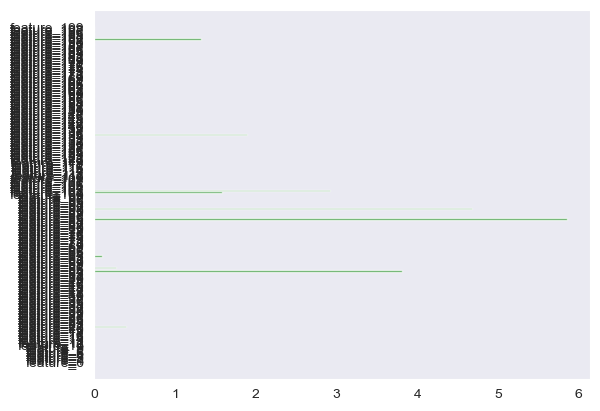

In [311]:
plt.barh(['feature_{}'.format(i) for i in range(M)],  np.mean(np.abs(shap_v),axis=0), color='green', alpha=0.7)

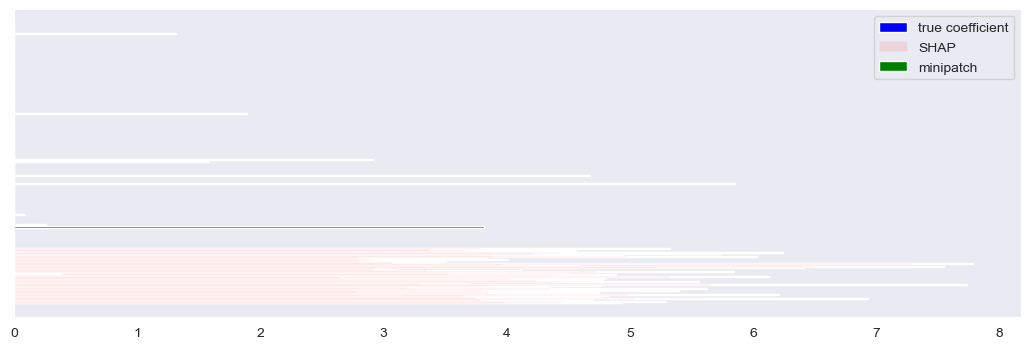

In [318]:
fig, ax = plt.subplots(1, 1, figsize=(13,4))
ax.barh(['feature_{}'.format(i) for i in range(M)], beta, color='blue', alpha=1)
ax.barh(['feature_{}'.format(i) for i in range(M)], np.mean(np.abs(kernel_shap_values.values),axis=0), color='red', alpha=0.1)
ax.barh(['feature_{}'.format(i) for i in range(M)], np.mean(np.abs(shap_v),axis=0), color='green', alpha=1)
ax.legend(['true coefficient','SHAP', 'minipatch'])
ax.yaxis.set_ticklabels([])
plt.savefig('./figures/NLM_shap_reg_3.svg')

In [1034]:

def shapley_mp(target_feature, res):
    pred, in_mp_obs, in_mp_feature = res
    pred = np.array(pred)
    n = np.sum(in_mp_obs, axis=1)[0]
    all_features = np.unique(in_mp_feature,axis=0) # get all features sampled in MPs
    # all_features is now one-hot encoding of the positions 
    features_target = all_features[np.where(all_features[:,target_feature]==False)] # ohe for the feature subsets that exclude target feature
    dk = features_target.shape[0]
    d = all_features.shape[0]
    
    diff = []
    for row in features_target:
        val_diff = 0 
        row_j = row.copy()
        row_j[target_feature] = True
    
        # get in in_mp_feature the corresponding elements 
        mask = np.all(in_mp_feature == row, axis=1)
        mask_j =  np.all(in_mp_feature == row_j, axis=1)
        if in_mp_feature[mask_j].shape[0] == 0:
            mu_j = np.zeros(1)
            mu_k = np.zeros(1)
        else:
            mu_k = np.mean(pred[mask,:,0],axis=0) 
            mu_j = np.mean(pred[mask_j,:,0], axis=0)
        val_diff = np.abs(y - mu_j) - np.abs(y - mu_k)
        diff.append(val_diff) # 1/binom(d-1,sum(row)) * 
    shapley_j = 1/d*sum(diff)
    return shapley_j


def mp_shapley(res):
    new_shap = np.zeros((res[1].shape[1],res[2].shape[1]))
    for i in tqdm.tqdm(range(res[2].shape[1])): 
        new_shap[:,i] = shapley_mp(i, res)
    return new_shap

In [1035]:
res = minipatch_regression(X, y, X, model, x_ratio, B)
shapley_mp(2,res).shape

(2000,)

In [1036]:
shap_values = mp_shapley(res)
shap_values.shape

100%|██████████| 20/20 [00:00<00:00, 70.62it/s]


(2000, 20)

In [1037]:
np.mean(beta)

2.0981079594699623

In [1040]:
np.mean(np.abs(shap_values))

0.016005050231108323

<BarContainer object of 20 artists>

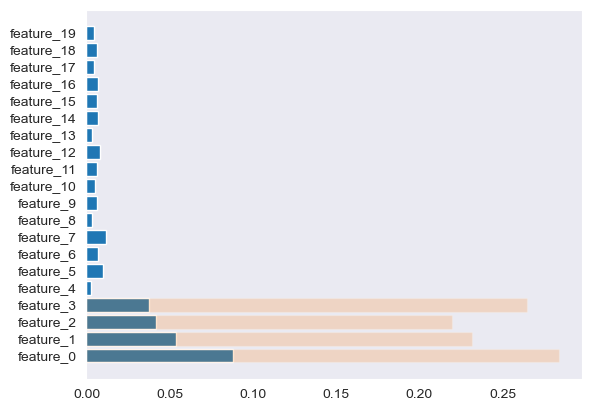

In [1046]:
plt.barh(['feature_{}'.format(i) for i in range(M)], np.mean(np.abs(shap_values), axis=0))
plt.barh(['feature_{}'.format(i) for i in range(M)], beta/np.sum(beta), alpha=0.2)

## Non independent features

### Toy example $M = $

In [997]:
def shapley_mp_delta(y, target_feature, res):
    pred, in_mp_obs, in_mp_loo, in_mp_feature = res
    pred = np.array(pred)
    n = np.sum(in_mp_obs, axis=1)[0]
    all_features = np.unique(in_mp_feature,axis=0) # get all features sampled in MPs
    # all_features is now one-hot encoding of the positions 
    features_target = all_features[np.where(all_features[:,target_feature]==False)] # ohe for the feature subsets that exclude target feature
    dk = features_target.shape[0]
    d = all_features.shape[0]
    
    diff = []
    for row in features_target:
        val_diff = 0 
        row_j = row.copy()
        row_j[target_feature] = True
    
        # get in in_mp_feature the corresponding elements 
        mask = np.all(in_mp_feature == row, axis=1)
        mask_j =  np.all(in_mp_feature == row_j, axis=1)
        if in_mp_feature[mask_j].shape[0] == 0:
            mu_j = np.zeros(1)
            mu_k = np.zeros(1)
        else:
            mu_k = np.mean(pred[mask,:,0],axis=0)
            mu_j = np.mean(pred[mask_j,:,0], axis=0)
        val_diff = np.abs(y-mu_j) - mu_k
        diff.append(1/binom(d-1,sum(row)) * val_diff)
    shapley_j = 1/d* sum(diff)
    return shapley_j

In [ ]:
def loco_error(X, y, Xi, model, x_ratio, B):
    N = len(X)
    M = len(X[0])
    Delta = np.zeros((N, M))
    pred, in_mp_obs, in_mp_feature = minipatch_regression(X, y, X, model, x_ratio, B)
    batch_size = np.sum(in_mp_obs, axis=1)[0] 
    for i in tqdm.tqdm(range(N)):
        indices_without_i = np.where(~in_mp_obs[:, i])[0] # batches without observation i
        predictions_i = pred[indices_without_i, :, 0] # predictions from batches trained without observation i on obs i (test sets of MP)
        mu_i = np.mean(predictions_i[:,i]) # average loo prediction of all 'test' out-of-batches 
        in_mp_feature_i = in_mp_feature[indices_without_i,:] # reduced feature matrix
        for j in range(M):
            # error of mu_j - error of mu
            mu_ij = np.mean(predictions_i[~np.where(in_mp_feature_i[:,j])[0],i]) # prediction without obs j with LOO i 
            err_j = np.mean(np.abs(y[i] - mu_ij)) # on minipatch without j 
            err = np.mean(np.abs(y[i] - mu_i)) # on all minipatches
        
            Delta[i,j] = err_j - err
        
    return Delta